In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.widgets import Button

import cv2
import numpy as np
import pandas as pd


# Fetch video you want to annotate

In [2]:
cap = cv2.VideoCapture("/Volumes/Extreme SSD/C02_170622120000.mp4")

ret,frame = cap.read()

# Track object 

In [3]:
class Track:
    
    def __init__(self,_id):
        self.id = _id
        self.trajectory = []
        
        
    def get_tracks(self):
        return self.tracks
    
    def get_id(self):
        return self.id
    
    def add_detection(self,data):
        
        self.trajectory.append(data)
        


# Give the BeeID you want to start annotating

In [4]:
f_num = 1
track = Track(input("Enter the ID of the Bee you want to annotate"))

Enter the ID of the Bee you want to annotate1


# This cell when executed will open a window outside of the browser where you'll see the current frame plotted. All you have to do is click on the center of the bee and it will be annotated and added in the Track object

<IPython.core.display.Javascript object>


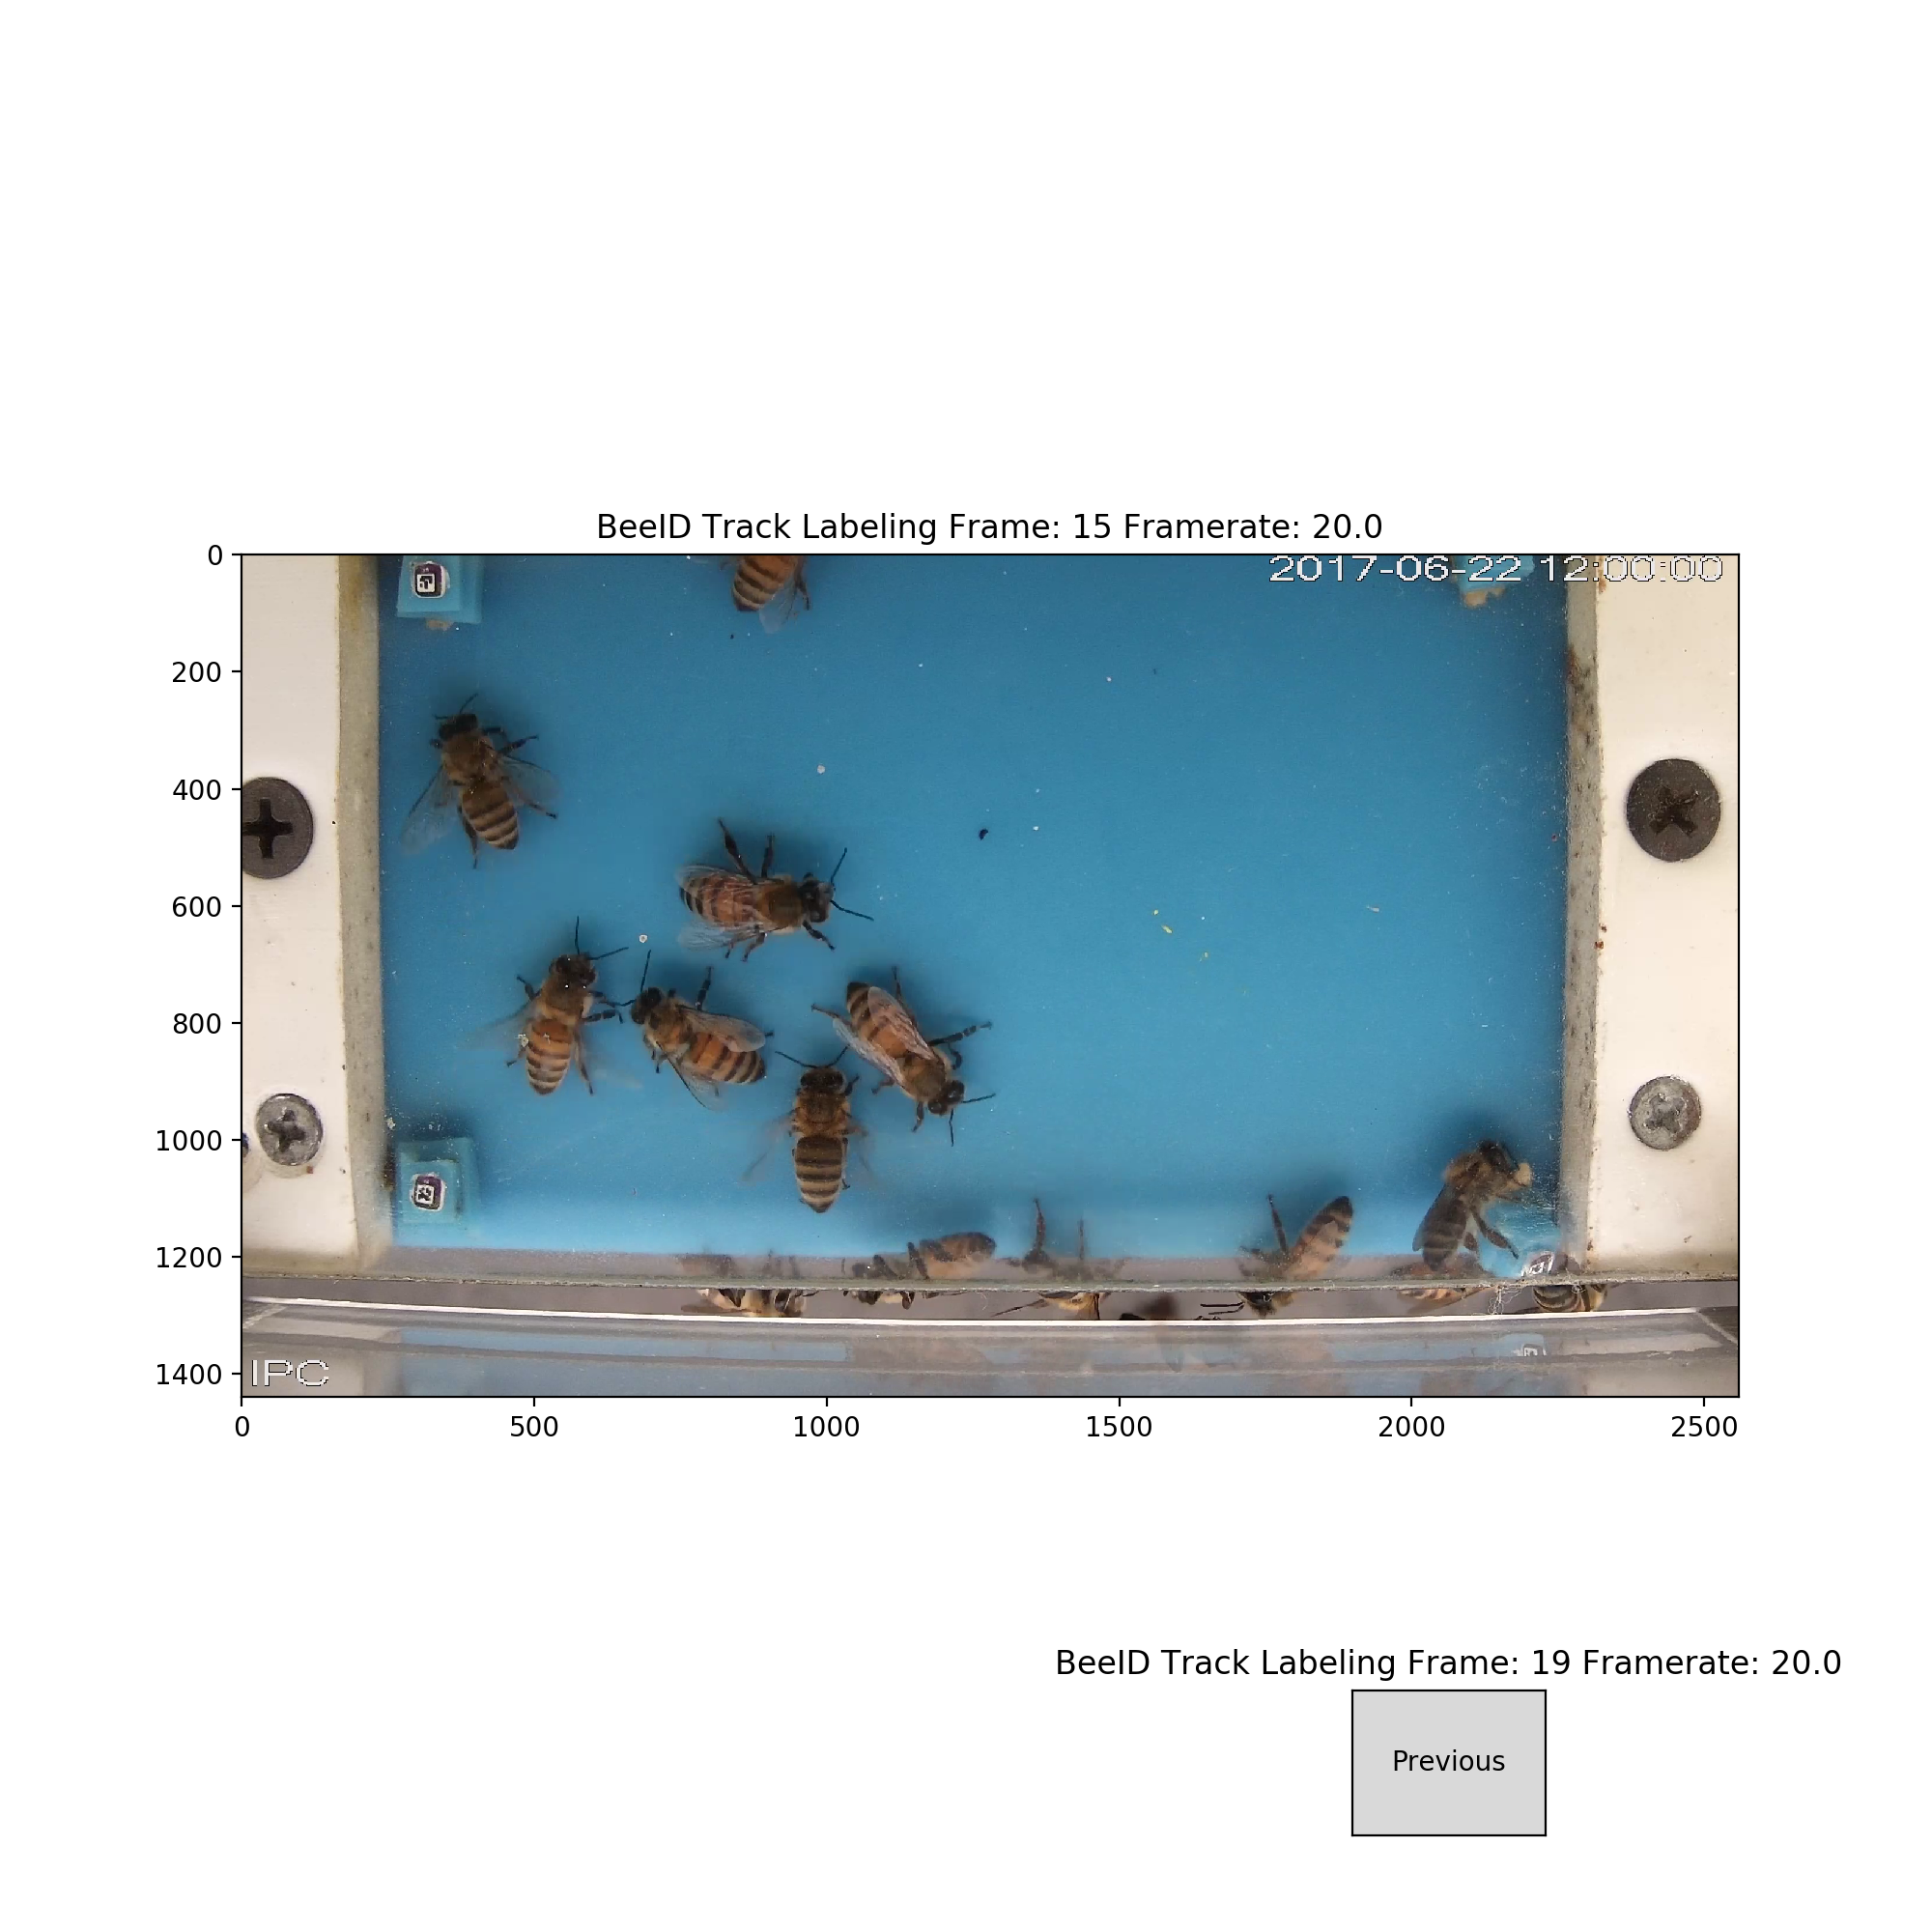

In [9]:
fig, ax = plt.subplots(figsize=(10,10))
frame = frame[...,::-1]



plt.title('BeeID Track Labeling Frame: '+str(f_num) + " Framerate: "+ str(cap.get(cv2.CAP_PROP_FPS)))

ax.imshow(frame)

done = False

def onclick(event):
    global f_num, ax
    
    print('xdata=%f, ydata=%f, frame=%f' %
          (event.xdata, event.ydata,f_num))
    
    track.add_detection({"x":event.xdata,"y":event.ydata,"frame":f_num})
    
    f_num+=1
    cap.set(1,f_num)
    
    ret,frame = cap.read()
    
    frame = frame[...,::-1]
    
    if not ret:
        done = True
    
        
    ax.imshow(frame)
    plt.title('BeeID Track Labeling Frame: '+str(f_num) + " Framerate: "+  str(cap.get(cv2.CAP_PROP_FPS)))
    plt.draw()
    

axprev = plt.axes([0.7, 0.05, 0.1, 0.075])
bprev = Button(axprev, 'Previous')



cid = fig.canvas.mpl_connect('button_press_event', onclick)




In [6]:
track.get_id()

'1'

In [11]:
track.trajectory

[{'x': 1785.4612903225807, 'y': 737.1516129032254, 'frame': 1},
 {'x': 1696.2741935483868, 'y': 763.5774193548384, 'frame': 2},
 {'x': 1666.5451612903225, 'y': 766.88064516129, 'frame': 3},
 {'x': 1633.5129032258064, 'y': 793.306451612903, 'frame': 4},
 {'x': 1600.4806451612903, 'y': 829.6419354838706, 'frame': 5},
 {'x': 1564.1451612903224, 'y': 869.2806451612901, 'frame': 6},
 {'x': 1501.383870967742, 'y': 935.3451612903223, 'frame': 7},
 {'x': 1484.867741935484, 'y': 974.9838709677417, 'frame': 8},
 {'x': 1474.958064516129, 'y': 1001.4096774193545, 'frame': 9},
 {'x': 1418.8032258064518, 'y': 1060.8677419354835, 'frame': 10},
 {'x': 1382.467741935484, 'y': 1097.2032258064514, 'frame': 11},
 {'x': 1379.164516129032, 'y': 1153.3580645161287, 'frame': 12},
 {'x': 1395.6806451612902, 'y': 1173.1774193548385, 'frame': 13},
 {'x': 1405.590322580645, 'y': 1249.1516129032257, 'frame': 14},
 {'x': 1002.5967741935484, 'y': 1001.4096774193545, 'frame': 15},
 {'x': 0.47671875000000075, 'y': 0.3

In [15]:
master = {}


In [16]:
master[track.id] = track.trajectory

In [17]:
master[1]

[{'x': 899.078494623656, 'y': 613.2132043010756, 'frame': 1},
 {'x': 868.2483870967743, 'y': 635.2347096774197, 'frame': 2},
 {'x': 885.8655913978495, 'y': 637.4368602150541, 'frame': 3},
 {'x': 905.6849462365591, 'y': 655.0540645161293, 'frame': 4},
 {'x': 921.1, 'y': 685.884172043011, 'frame': 5},
 {'x': 936.515053763441, 'y': 725.5228817204304, 'frame': 6},
 {'x': 947.525806451613, 'y': 725.5228817204304, 'frame': 7},
 {'x': 958.536559139785, 'y': 718.916430107527, 'frame': 8},
 {'x': 947.525806451613, 'y': 707.905677419355, 'frame': 9},
 {'x': 938.7172043010752, 'y': 696.894924731183, 'frame': 10},
 {'x': 936.515053763441, 'y': 692.4906236559143, 'frame': 11},
 {'x': 938.7172043010752, 'y': 690.2884731182799, 'frame': 12},
 {'x': 967.3451612903226, 'y': 718.916430107527, 'frame': 13}]

In [18]:
def add_to_master(master_dt,new_track):
    master_dt[new_track.id] = new_track.trajectories
    

In [ ]:
add_to_master(master,track)

In [25]:


df = pd.DataFrame.from_dict(master)

df.to_csv("Trajectories.csv",index=False)
